# Plotting

In [1]:
import matplotlib.pyplot as plt
import json, os
import pandas as pd

In [2]:
from pathlib import Path

def list_files(directory, ext='h5'):
    return [str(file) for file in Path(directory).rglob(f"*.{ext}")]

In [3]:
results = {
    'data': [],
    'total_execution_time (seconds)': [],
    'total_process_memory (MB)': [],
    'throughput_bps': [],
    'sample_persec': []
}
device = 'cpu'

# Read from the total.json file instead of individual files
with open(f'./{device}/total.json', 'r') as input:
    data_list = json.load(input)
    
    for data in data_list:
        results['total_execution_time (seconds)'].append(
            data['total_execution_time (seconds)']
        )
        results['total_process_memory (MB)'].append(
            data['total_process_memory (MB)']
        )
        results['throughput_bps'].append(
            data['throughput_bps']
        )
        results['sample_persec'].append(
            data['sample_persec'][0]
        )
        results['data'].append(data['GB_processed'])

In [7]:
df = pd.DataFrame(results)
df.head(3)

data  total_execution_time (seconds)  total_process_memory (MB)  \
0     1                      236.021310                1635.035156   
1     2                      445.104459                1635.039062   
2     3                      647.429533                1609.667969   

   throughput_bps  sample_persec  
0    3.667949e+07     223.437451  
1    3.889937e+07     236.960107  
2    4.011467e+07     244.363273

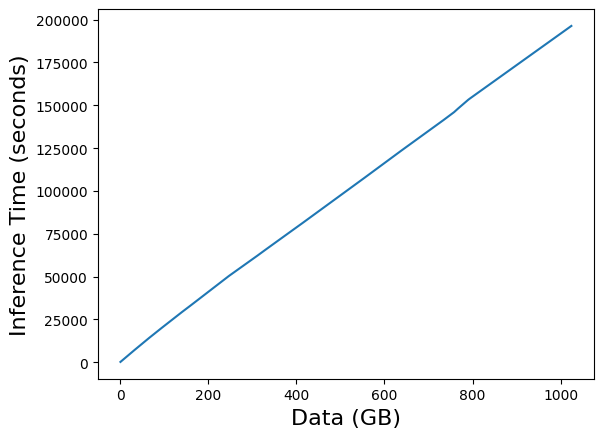

In [5]:
plt.plot(df['data'], df['total_execution_time (seconds)'])
plt.xlabel('Data (GB)', fontsize=16)
plt.ylabel('Inference Time (seconds)', fontsize=16)
# plt.savefig(f'./outputs/{device}.jpg', bbox_inches='tight')
plt.show()

# Summarize Extended Results

In [54]:
import numpy as np

def remove_outliers_and_mean(data, threshold=1.5):
    """
    Removes outliers from the data and calculates the mean of the remaining values.

    Args:
        data (list or array): The data to process.
        threshold (float): The IQR multiplier for outlier detection.

    Returns:
        float: The mean of the data after removing outliers.
    """

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]

    return np.mean(filtered_data)

gb_splits = [100, 256, 512, 768, 1024]
runs = 3

results = {
    'data (GB)': [],
    'run':[],
    'total_execution_time (seconds)': [],
    'total_process_memory (MB)': [],
    'throughput_bps': [],
    'sample_persec': []
}
stat_keys = [key for key in results if key not in ['data (GB)', 'run']]

for gb in gb_splits:
    data_dir = f'results2/{gb}GB'
    
    for run in range(1, runs+1):
        split_results = {key:[] for key in stat_keys}
        json_files = list_files(f'{data_dir}/{run}', 'json')

        for json_file in json_files:
            with open(json_file, 'r') as input:
                data_list = json.load(input)
                for data_ in data_list:

                    data = data_['stats']
                    split_results['total_execution_time (seconds)'].append(
                        data['total_execution_time (seconds)']
                    )
                    split_results['total_process_memory (MB)'].append(
                        data['total_process_memory (MB)']
                    )
                    split_results['throughput_bps'].append(
                        data['throughput_bps']
                    )
                    split_results['sample_persec'].append(
                        data['sample_persec'][0]
                    )
        results['data (GB)'].append(gb)
        results['run'].append(run)

        results['total_execution_time (seconds)'].append(
            remove_outliers_and_mean(split_results['total_execution_time (seconds)'])
            # np.mean(split_results['total_execution_time (seconds)'])
        )
        results['throughput_bps'].append(np.sum(split_results['throughput_bps']))
        results['total_process_memory (MB)'].append(np.sum(split_results['total_process_memory (MB)']))
        results['sample_persec'].append(np.sum(split_results['sample_persec']))

In [55]:
results_df = pd.DataFrame(results)

In [56]:
mean_df = results_df.groupby('data (GB)')[stat_keys].mean().reset_index()
mean_df['run'] = 'mean'
mean_df = mean_df[results_df.columns]
mean_df

data (GB)   run  total_execution_time (seconds)  total_process_memory (MB)  \
0        100  mean                       25.926221               7.861700e+05   
1        256  mean                       27.017528               2.009762e+06   
2        512  mean                       27.325015               4.024040e+06   
3        768  mean                       26.619135               6.034721e+06   
4       1024  mean                       26.486518               8.049228e+06   

   throughput_bps  sample_persec  
0    3.317738e+10   2.021039e+05  
1    8.133820e+10   4.954812e+05  
2    1.579578e+11   9.622183e+05  
3    2.485102e+11   1.513829e+06  
4    3.332215e+11   2.029858e+06

In [57]:
results_df = pd.concat([results_df, mean_df], axis=0).sort_values('data (GB)').reset_index(drop=True)

In [ ]:
# results_df['total_bits'] = results_df['throughput_bps'] * results_df['total_execution_time (seconds)']


In [58]:
results_df.round(2).to_csv('./results2/result_stats.csv', index=False)